# Magic the Gathering Card Price Prediction
*David Mitchell, Vasiliy Melkozerov, Jason Turner, Stephen FitzSimon*

## Key Takeaways
- Takeaway 1

## Contents <a name='contents'></a>
1. <a href='#intro'>Introduction</a>
2. <a href='#explore'>Explore</a>
    1. <a href='#q_1'>Question 1</a>
3. <a href='#model'>Modeling</a>
    1. <a href='#baseline'>Basline Model</a>
    2. <a href='#train_validate_model'>Modeling on Train and Validate</a>
    3. <a href='#final_model'>Final Model</a>
4. <a href='#conclusions'>Conclusions</a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd

# Import statistical module
from scipy import stats

# Import custom modules
import acquire
import prepare
import explore
# import model

# Ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

## Wrangle

In [2]:
# Acquire and prepare data returned as a dataframe
df = acquire.get_data(query_url = False)
print(df.shape)
df = prepare.prepare_dataframe(df)
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((40311, 60), (6719, 60), (6719, 60))

## Introduction <a name='intro'></a>

<a href='#contents'>Return to Contents</a>

# Explore

### Key Explore Takeaways
- Takeaway 1

### Discussion

<a href='#contents'>Return to Contents</a>

## Vasily's EDA & Hypotheses

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">


<a name='q_1'></a>
### Does legality affect the price?

#### Key Takeaways
- The legality of a card does have an affect on price.
- The effect is disproportionate among the legalities.
- The difference in the price is dependent on what legalities the card is in.

### Discussion

The goal was to find tangible differences in the Key Takeaways for price based off of its legality.

#### Visualization

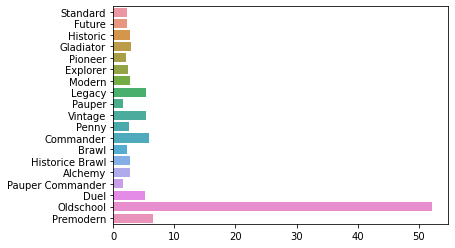

In [3]:
explore.get_legalites_chart(train)

#### Hypothesis Testing
$H_0$: There is no correlation between legality and USD price.

$H_a$: There is a correlation between legality and USD price.

In [4]:
explore.hypothesis_test_legalities(train)

10.412185191299939 1.1746763888223343e-25 0.05
We reject the null hypothesis


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_2'></a>
### Is there a difference in price between sets?

#### Key Takeaways
- There is a large difference in price between some sets.
- Most of the sets that have gone through standard are roughly worth the same.

### Discussion
The initial assumption going into this is that not all sets are worth the same amount. Some more then others and some in the class of commodities.

#### Visualization

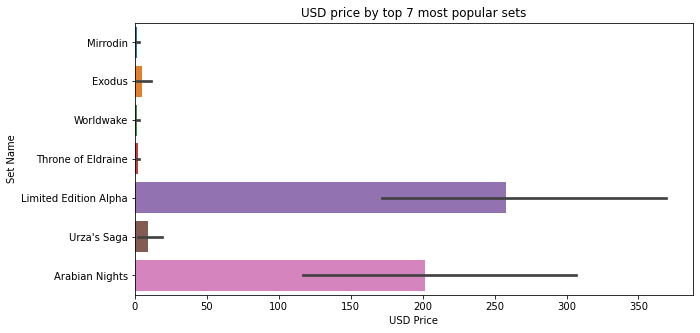

In [5]:
explore.top_7_sets(train)

#### Hypothesis Testing
$H_0$: There is no correlation between the set name and USD price.

$H_a$: There is a correlation between the set name and USD price.

In [6]:
explore.hypothesis_test_set_name(train)

11.500764578143793 7.297024862617009e-31 0.05
We reject the null hypothesis


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_3'></a>
### Is combined mana cost a good indicator for price?

#### Key Takeaway
- At 0, 11, and 13 mana cost there is a statistically significant difference in price compared to the mean.

### Discussion
CMC stands for combined mana cost. Idea here being that the more "rare" and obscure a card is the more valuable it may be. Oddly enough the more mana expensive a card is it goes up in value after 8 mana.

#### Visualization

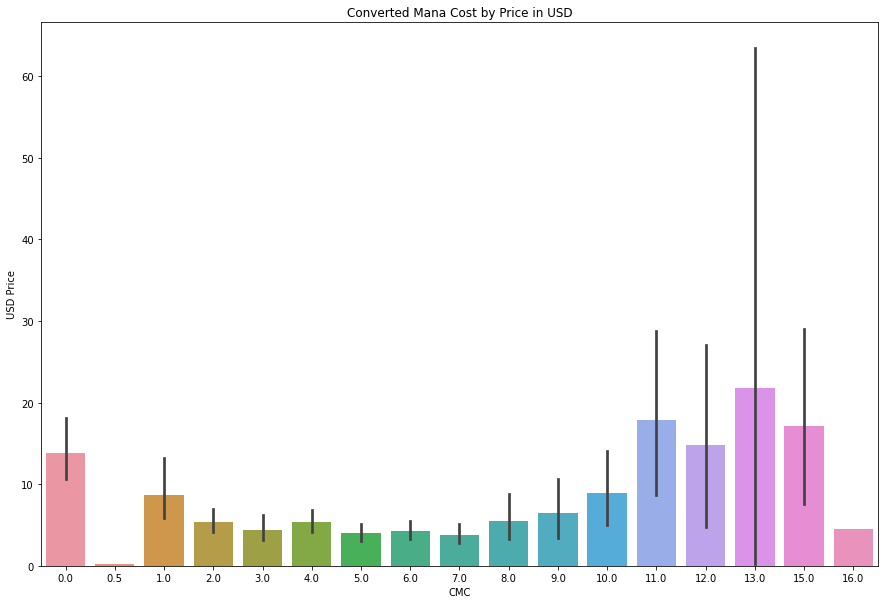

In [7]:
explore.cmc_by_price(train)

#### Hypothesis Testing
$H_0$: There is no correlation between the release date and USD price.

$H_a$: There is a correlation between the release date and USD price.

In [8]:
explore.hypothesis_test_cmc(train).sort_values('reject_null', ascending = False).head(5)

,mana_cost,cost_mean,t_stat,p_value,reject_null
13,11.0,17.896667,2.193620,0.042454,True
6,0.0,13.848302,3.815167,0.000138,True
10,15.0,17.096250,1.904770,0.098513,True
0,4.0,5.318918,-1.703086,0.088600,False
9,10.0,8.971642,1.065848,0.290376,False


## Stephen's EDA & Hypotheses

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_1'></a>
### What effect does the release date have on the price?

#### Key Takeaway
- 1993, 1994 and 1999 have a higher than average price for cards released in those years.

### Discussion
In charting the USD price as a line graph, it appears that there are spikes in the price in the '90s, and possible in the '20s. In charting mean price per year in a (FIX)

## Visualization

It looks like the mid '90s, just before '00, and post-'20 might have higher prices

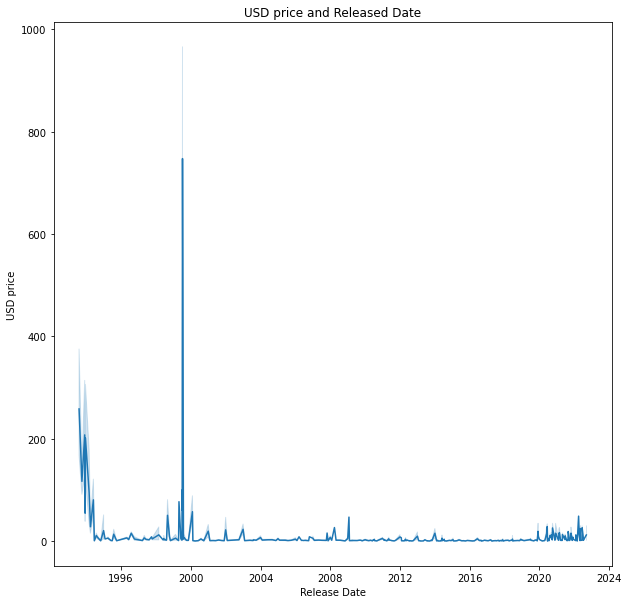

In [9]:
explore.vis_usd_by_released_at(train)

Looks like '93 and '94 have the highest average price, followed by '98 and '99. The spikes in the line graph are not affecting the average price in the year.

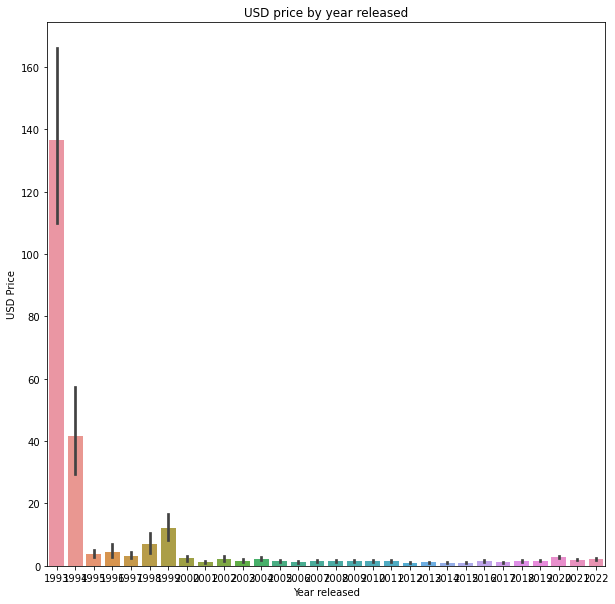

In [10]:
explore.vis_usd_by_year(train)

## Hypothesis Testing

$H_0$: Year $x$ has a average price per card equal to or less than the general average price.

$H_a$: Year $x$ has a average price per card greater than the general average price.

In [11]:
explore.hypothesis_test_years(train).sort_values('reject_null', ascending = False).head(5)

,year,year_mean,t_stat,p_value,reject_null
24,1994,41.753568,5.076309,4.697974e-07,True
23,1993,136.695879,9.072537,6.133079e-19,True
20,1999,11.965388,2.540423,1.119745e-02,True
0,2017,1.191322,-59.796312,0.000000e+00,False
1,2001,1.308977,-37.885491,2.464977e-182,False


The null is likely wrong for '93, '99 and '94.  These years have a higher than average price for their cards.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_2'></a>
What affect does basic card type have on price?

#### Key Takeaway
- Land, artifacts, enchantment and legendary are priced higher than other cards

### Discussion
Land, artifact, enchantment and legendary cards have a statistically higher price than other cards. Some further questions to be asked is if these card types have more rares or particular artists.  In addition, it might be worth looking at subsets of some of these.

#### Visualization

Definitely looks like the card type has an effect.

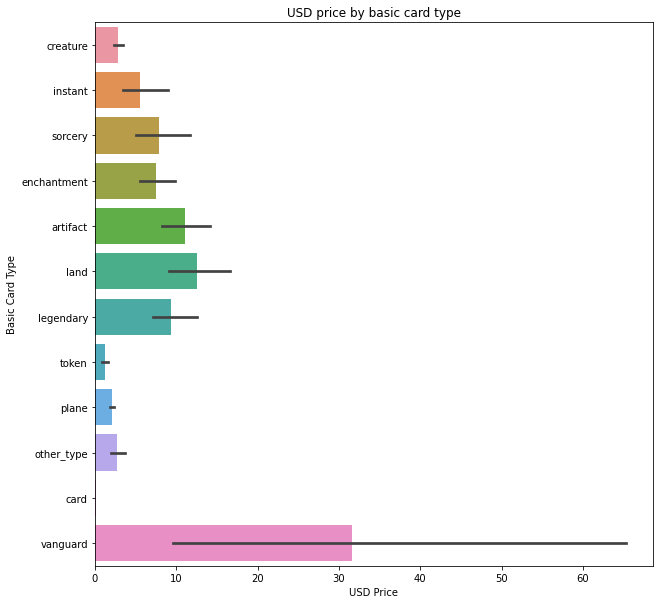

,count,mean,std,min,25%,50%,75%,max
card_type,,,,,,,,
artifact,3891.0,11.059594,95.527098,0.01,0.1200,0.290,1.7900,3099.99
card,20.0,0.120000,0.089912,0.01,0.0550,0.090,0.1875,0.30
creature,15127.0,2.840369,31.472724,0.01,0.0700,0.150,0.3900,2499.94
enchantment,4034.0,7.475025,68.037474,0.01,0.1100,0.260,1.9400,2849.99
instant,4859.0,5.551062,105.282756,0.01,0.0800,0.170,0.5700,6999.99
land,4140.0,12.530761,131.352571,0.03,0.1400,0.260,1.4800,6000.00
legendary,2827.0,9.310007,79.840352,0.01,0.3300,1.510,5.5150,3888.00
other_type,143.0,2.769161,5.140162,0.05,0.2750,0.790,2.7150,38.14
plane,120.0,2.065583,1.480464,0.52,1.3475,1.690,2.4250,14.42


In [12]:
explore.vis_by_card_type(train)
explore.make_card_type_column(train).groupby('card_type').usd.describe()

#### Hypothesis Testing

$H_0$: Mean price for card type $x$ is less than or equal to the overall mean price.

$H_a$: Mean price for card type $x$ is greater than the overall mean price.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_3'></a>
### What effect does the game style (arena etc) have on price?

#### Key Takeaway
- Cards available exclusively in the paper game are more valuable than ones also available in other games.

### Discussion
Each card is tested by its inclusion in each game type, and cards that are in the paper game exclusively are more expensive. Inclusion into the other game types appears to lower the value of the card.

### Notes
The column contains a list of options to make a number of boolean columns to visualize.

#### Visualization
Cards that are in the paper game are definitely more valuable than cards available only in the non-paper game.

In [13]:
explore.hypothesis_test_card_type(train).sort_values('reject_null', ascending = False)

,card_type,overall_mean,card_type_mean,t_stat,p_value,reject_null
4,artifact,6.433689,11.241445,3.088901,2.023393e-03,True
5,land,6.433689,12.530761,2.986640,2.837148e-03,True
6,legendary,6.433689,9.316591,1.918514,5.514653e-02,True
0,creature,6.433689,2.951802,-13.093473,5.956357e-39,False
1,instant,6.433689,5.694970,-0.476732,6.335749e-01,False
2,sorcery,6.433689,8.065635,0.970315,3.319422e-01,False
3,enchantment,6.433689,7.580113,1.055432,2.912921e-01,False
7,token,6.433689,1.227304,-28.030601,3.789460e-111,False
8,plane,6.433689,2.065583,-32.321076,9.222349e-61,False
9,other_type,6.433689,2.769161,-8.525292,2.040294e-14,False


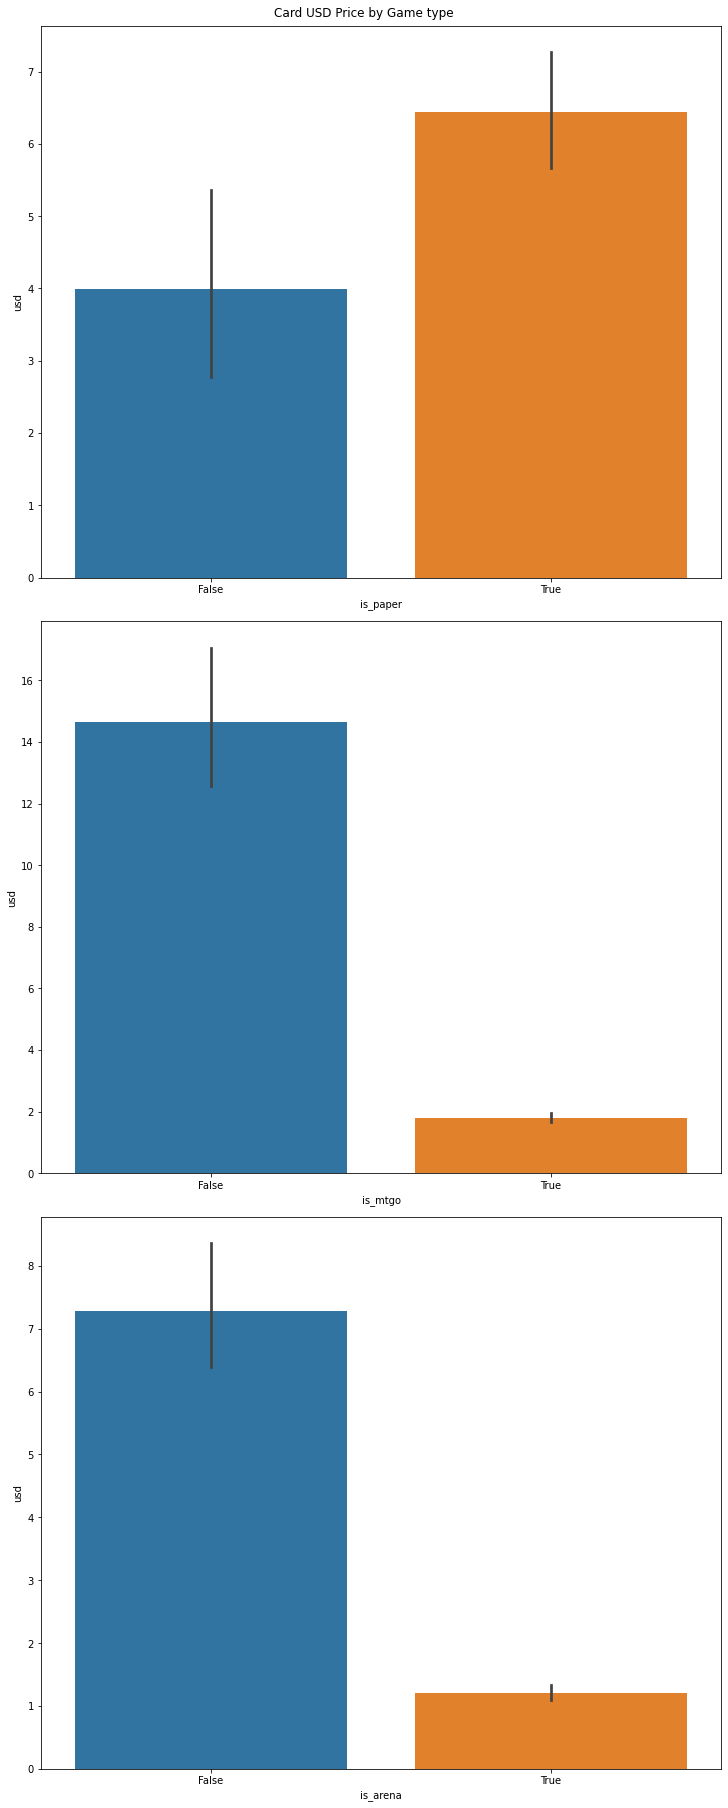

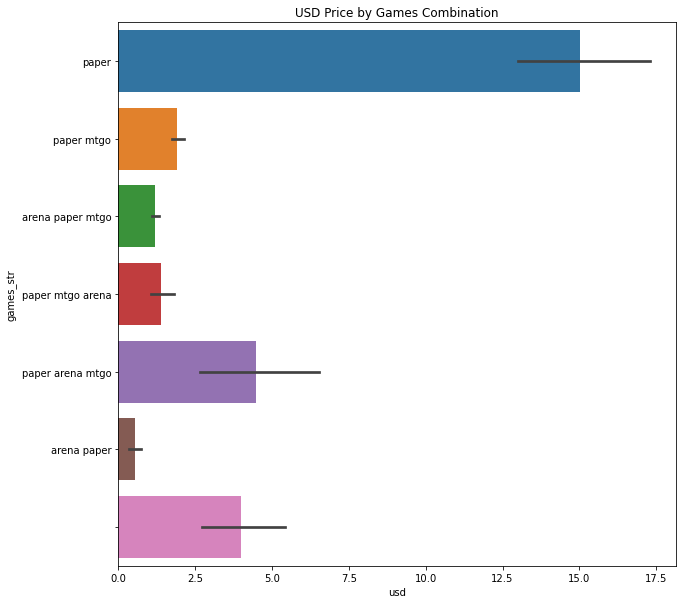

In [14]:
explore.vis_game_type(train)
explore.vis_game_type_by_combo(train)

#### Hypothesis Testing
$H_0$: The mean usd price for cards which are available in game type $x$ is less than or equal to the mean usd price of those not available in game type $x$.

$H_a$: The mean usd price for cards which are available in game type $x$ is greater than the mean usd price of those not available in game type $x$.

Where $x$ is paper, astral, mtgo, arena, or sega.

In [15]:
explore.hypothesis_test_game_type(train).sort_values('reject_null', ascending=False)

,game_type,card_count,game_type_mean,t_stat,p_value,reject_null
0,is_paper,39356,6.437399,0.009104,0.992737,False
1,is_mtgo,24922,1.787554,-63.769316,0.000000,False
2,is_arena,5072,1.205419,-87.500291,0.000000,False


$H_0$ : The mean usd price for cards which are available $l$ games is less than or equal to the mean usd price of those not available in $l$ games.

$H_a$ : The mean usd price for cards which are available $l$ games is greater than the mean usd price of those not available in $l$ games.

Where $l$ is one of the following combinations: 
- 'paper'
- 'paper', 'mtgo'
- 'arena', 'paper', 'mtgo'
- 'mtgo'
- 'arena'
- 'paper', 'mtgo', 'arena'
- 'arena', 'paper'
- no combination
- 'paper', 'arena', 'mtgo'
- 'astral'
- 'sega'

In [16]:
explore.hypothesis_test_game_type_combinations(train).sort_values('reject_null', ascending=False)

,games_combination,card_count,in_sample_mean,t_stat,p_value,reject_null
1,paper,14132,15.018361,7.490320,7.276010e-14,True
0,paper mtgo,20152,1.927415,-49.955943,0.000000e+00,False
2,arena paper mtgo,4163,1.202358,-78.480391,0.000000e+00,False
3,paper mtgo arena,572,1.386755,-26.366627,2.007565e-104,False
4,arena paper,302,0.530062,-58.087016,4.910872e-172,False
5,,61,3.985574,-3.507827,8.626413e-04,False
6,paper arena mtgo,35,4.466000,-1.991392,5.452106e-02,False


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_4'></a>
### What is the overlap between card types and rarity?

#### Key Takeaway
- Certain combinations of rarity and card type are more valuable than others; for example, rare enchantments are more valuable--but an enchantment card is not above average by itself.

### Discussion

USD price is only significant for artifact, land and legendary; however, when some cards are also a certain rarity, then they become valuable.  This indicates that these two columns should both be used in the model together to try to capture the more valuable cards.

#### Visualization
Rare and mythic cards are the most expensive.  However, there are not very many mythic cards.

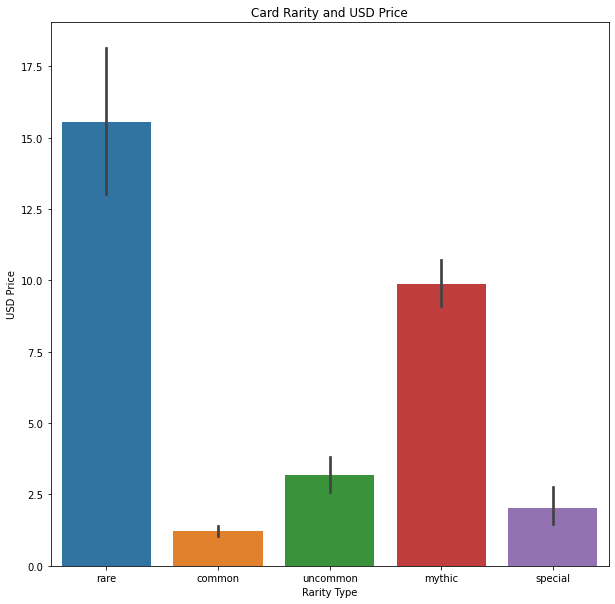

In [17]:
explore.viz_rarity_price(train)

It looks like for mythic tends to have more legendary.  Creatures are more represented in the other card types. Since the uncommon, rare and mythic cards are more expensive, is there a difference in the prices of the different card types?

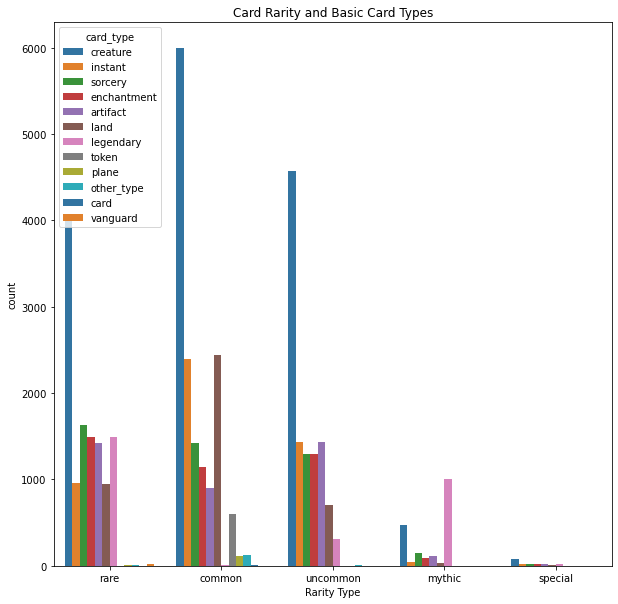

In [18]:
explore.viz_card_type_rarity(train)

Within the most expensive rarity types, land and artifact card types were still more expensive.

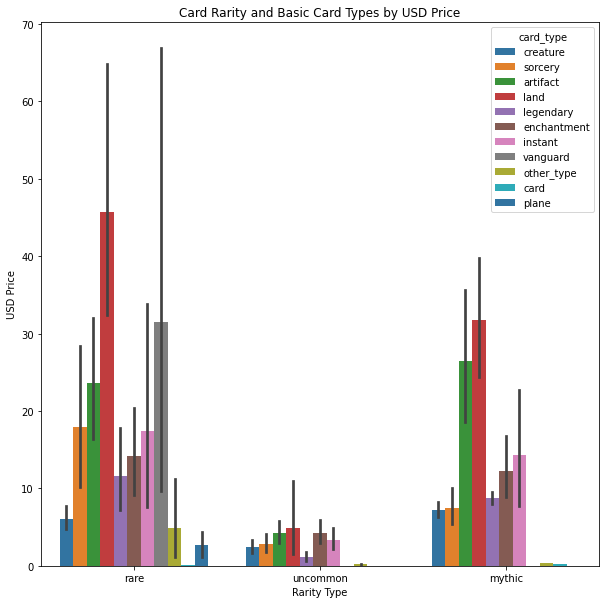

In [19]:
explore.viz_rare_uncommon_card_type_prices(train)

#### Hypothesis Testing
$H_0$: Cards of $raritytype$ and $cardtype$ have a mean value less than or equal to the overall card mean value.

$H_a$: Cards of $raritytype$ and $cardtype$ have a mean value greater than the overall card mean value.

Where $raritytype$ is one of 'rare', 'uncommon', 'mythic', and $cardtype$ is any basic card type from the `card_type` columns.

In [20]:
explore.rarity_card_type_hypothesis_tests(train).sort_values('reject_null', ascending=False).head(15)

,rarity_type,card_type,overall_mean,subgroup_mean,t_stat,p_value,reject_null
2,rare,land,6.433689,45.751851,4.609644,4.584154e-06,True
3,rare,artifact,6.433689,23.564593,4.209475,2.719814e-05,True
5,rare,enchantment,6.433689,14.174143,2.765816,5.748335e-03,True
6,rare,legendary,6.433689,11.543221,1.800819,7.193407e-02,True
25,mythic,enchantment,6.433689,12.280000,2.884459,4.894132e-03,True
24,mythic,instant,6.433689,14.350465,2.030992,4.861689e-02,True
23,mythic,artifact,6.433689,26.505000,4.598121,1.173936e-05,True
20,mythic,land,6.433689,31.773333,6.324940,6.557570e-07,True
19,mythic,legendary,6.433689,8.725692,5.351288,1.081975e-07,True
1,rare,sorcery,6.433689,17.913771,2.536849,1.127783e-02,True


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_5'></a>
### What effect does lang have on the price?

#### Key Takeaways
(Fix)

### Discussion
(Fix)

#### Visualization
It looks like the French cards are the most expensive.

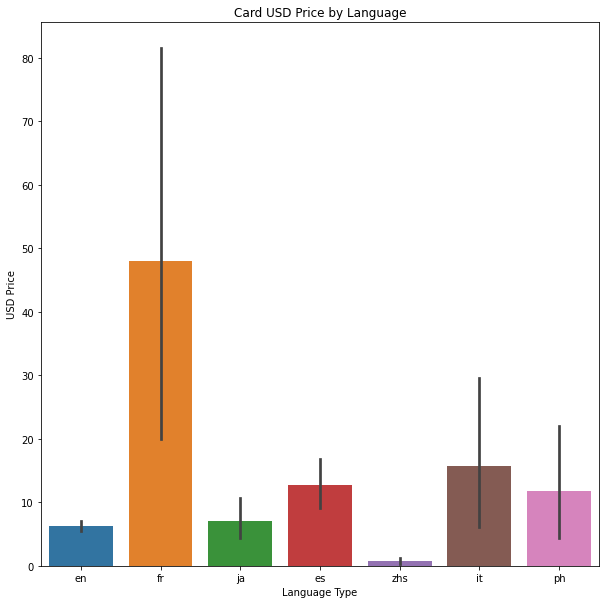

In [21]:
explore.viz_lang_column_usd(train)

#### Hypothesis Testing
$H_0$: (Fix)

$H_a$: (Fix)

In [22]:
explore.lang_hypothesis_test(train).sort_values('reject_null', ascending=False)

,langauge,overall_mean,legality_mean,t_value,p_value,reject_null
1,fr,6.433689,47.988393,2.507406,1.360934e-02,True
3,es,6.433689,12.751308,3.299197,1.253594e-03,True
0,en,6.433689,6.292161,-0.346722,7.288024e-01,False
2,ja,6.433689,7.105481,0.381300,7.037661e-01,False
4,zhs,6.433689,0.714286,-24.062587,8.941103e-20,False
5,it,6.433689,15.722692,1.340509,1.921353e-01,False
6,ph,6.433689,11.755000,1.031976,3.779905e-01,False


## David's EDA & Hypotheses

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_1'></a>
### Does the artist have any effect on the price of the card?

#### Key Takeaways
- The amount of cards created by and individual artist is not equal to the artist value. 
- In the charts, artist Jon Avon created the most cards but the artist Christopher Rush created the most expensive card (Black Lotus)

### Discussion
While some artist have created more cards then others, it appears that the amount of cards created is not equal to the value of the cards.

#### Visualization
It looks like the mid '90s, just before '00, and post-'20 might have higher prices.


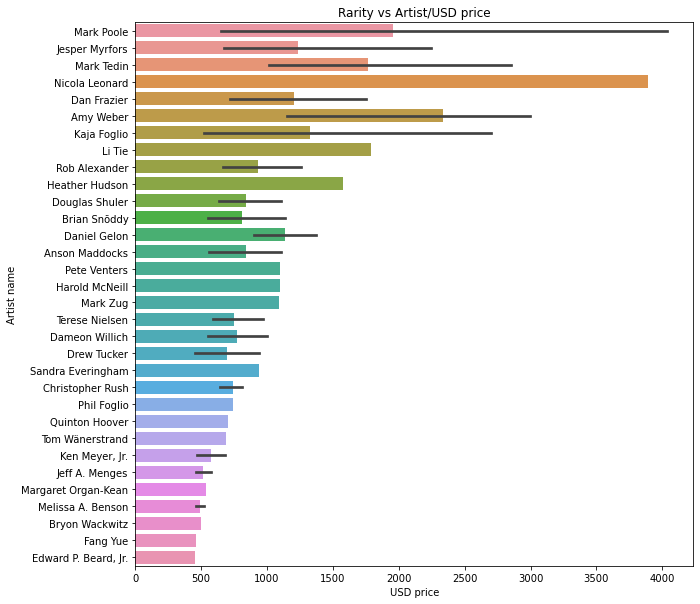

In [23]:
# Bar plot to show Artist and USD price, for top artist
explore.vis_artist_by_usd(train)

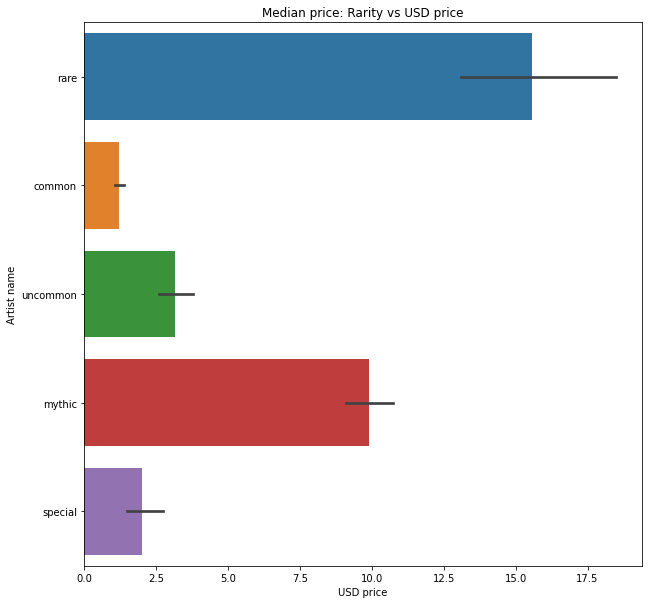

In [24]:
# Median price for all cards based on Rarity and USD price
explore.vis_rarity_by_usd(train)

#### Hypothesis Testing
$H_0$: The amount of cards created is equal to the artist value.

$H_a$: The amount of cards created is not equal to the artist value.

(Fix by adding statistical test or move visualizations down here?)

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_2'></a>
### Does the Rarity of the card have any effect on the card price?

#### Key Takeaways
- The rarity of cards is not the total indicator of the price. 
- In the charts while uncommon there are some non-rare card in the high value price range.

### Discussion
The rarity of the card and Artist have no effect on the card price. Will need more information in the future to see if higher price cards are more affected by tournament play and age of the card.

#### Visualization

Rarity of the cards has some --- on the value of the card more analysis more information is need to tell if it is a predictor of the card price.

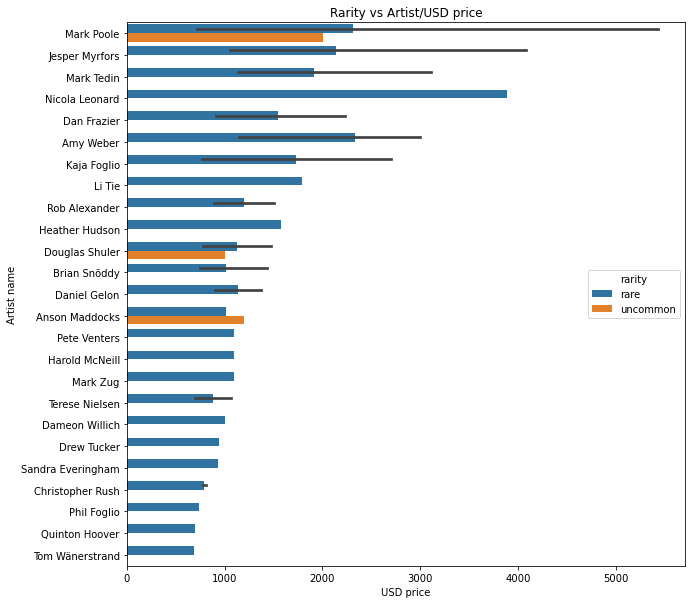

In [25]:
# Bar plot to show Artist, USD price and top 60 cards in the rarity category
explore.vis_artist_rarity_usd(train)

#### Hypothesis Testing

$H_0$: The artist and rarity of cards is equal to price.

$H_a$: The artist and rarity of cards is not equal to price.

(Fix by adding statistical test or move visualizations down here?)

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_3'></a>
### Does the set type and rarity of the cards affect the USD price?

#### Key Takeaways
- The set type and rarity of cards is not equal to price. 
- Some set types are older so we would have to evaluate the category to better understand this hypothesis.
- Rare cards are the most expensive regardless of set type
- In the charts there are only a few none rare cards in the top 100 high value price range.

### Discussion

While set type and rarity of the card do have some effect on the card's value more information is needed to see if this determines the value.

From ANOVA analysis, we know that set_type differences are statistically significant, but ANOVA does not tell which set_type are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

#### Visualization
Rarity of the cards has some --- (fix?) on the value of the card more analysis more information is need to tell if it is a predictor of the card price.

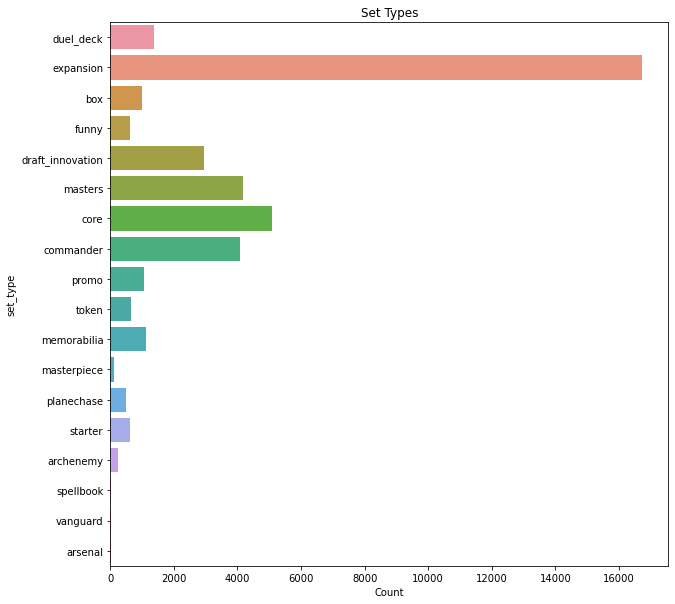

In [26]:
# Most expensive cards by set type.
explore.viz_expensive_cards_by_set_type(train)

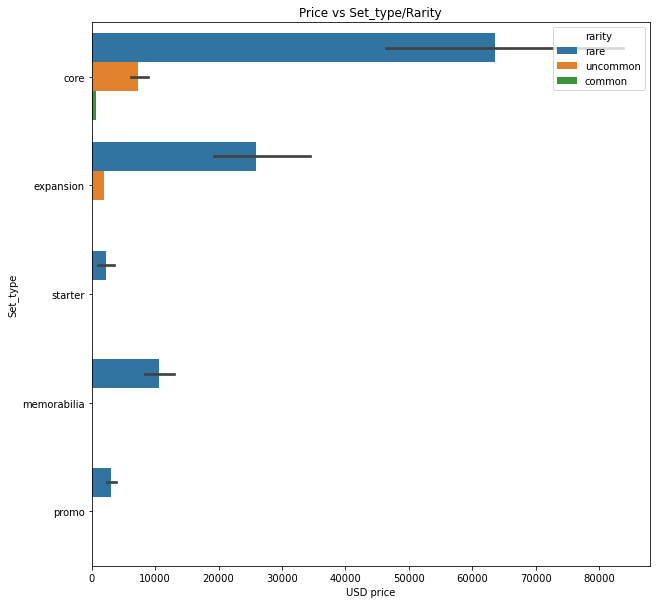

In [27]:
# The top 100 cards by set type and rarity
explore.usd_rarity_set_type_total(train)

#### Hypothesis Testing
$H_0$: The set type and rarity of cards is equal to the price. 

$H_A$: The set type and rarity of cards is not equal to the price.

(Fix by adding statistical test or move visualizations down here?)

## Key takeaway
- Rare cards are the most expensive regardless of set_type
- In the charts there are only a few none rare cards in the top 100 high value price range.


## Jason's EDA and Hypotheses


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_1'></a>
### Is there a significant difference in USD between non-foil only cards and non-foil cards with foil versions?

#### Key Takeaway
- Taking into account all sets the difference in favor of non-foil only cards is about $10.91

### Discussion

Found the null hypothesis to be false and the alternative hypothesis to be true. That there is a statistically significant difference between the prices of cards that are only non-foil and cards with both foil & non-foil versions.

The difference isn't in the way I initially anticipated as foil cards are supposed to be the premium product and rarer in general, but the non-foil onlys were almost seven times more expensive.  I suspect that the cards that only come in non-foil are much older on average than those with both foil and non-foil versions.

I set up the functions to account for any cards that come in foil but not in non-foil, however it appears that there non-foil versions of all cards but I'll leave it as is in case that changes in the future. 

There appear to be some large outliers for both non-foil only and both foil & non-foil sets.  The non-foil onlys have much higher outliers in USD but may be less extreme in relation to the rest of the non-foil onlys in comparison to the cards with both foil and non-foil versions.

#### Visualization

Bar plot comparing cards that are only non-foils to those that have both foil & non-foil version.

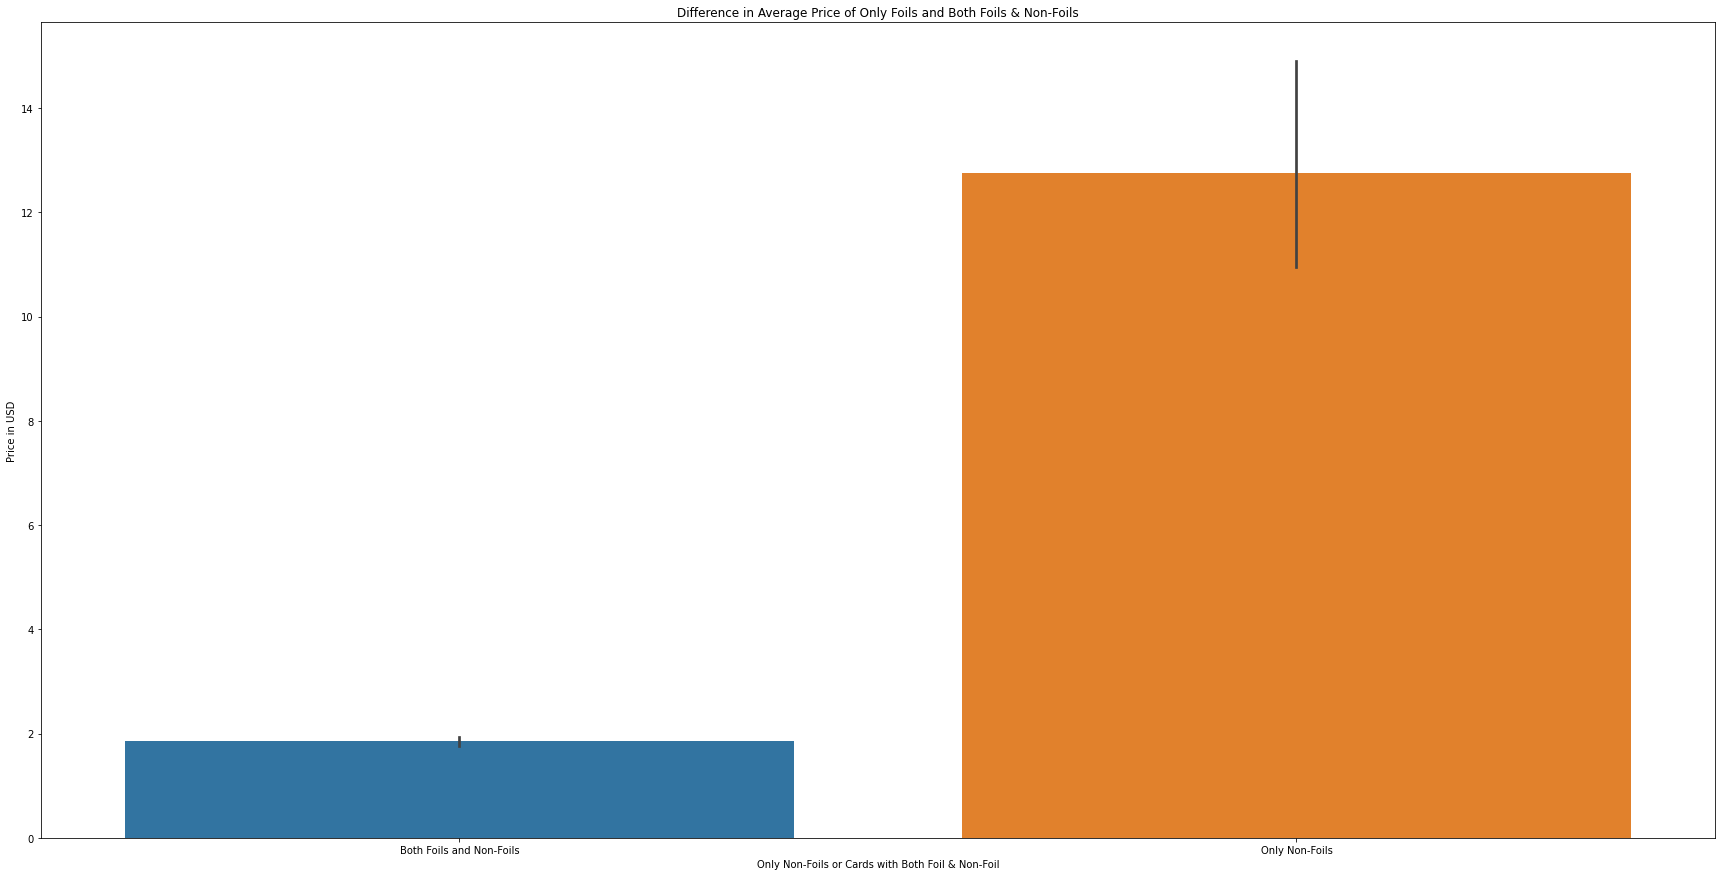

(None,
 'The average USD price of non-foil only cards is $12.76,  and for cards with both foil and non-foil is $1.85. The difference in average price is $10.91.')

In [28]:
# Creates a bar plot for columns in the dataframe for if it's non-foil only or not.
explore.nonfoil_only_or_not_viz(train)

#### Hypothesis Testing
95% significance level: α = 0.05

$H_0$: There is not a signficant difference between foil & non-foil cards.

$H_a$: There is a significant difference between foil & non-foil cards.

In [29]:
# # Hypothesis testing for question one using Two-sample T-Test with a 95% confidence interval.
explore.hypothesis_test_foil_vs_nonfoil(train)

Variance for non-foil only cards is 15743.686.
Variance for cards with both foil and non-foil cards is 50.2.
The t-statistic of -11.302 is less than 0, and the p-value of 8.201e-30 is statistically significant.
We reject the Null Hypothesis


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_1'></a>
### What’s the difference in card prices for reprints versus first printings?

#### Key Takeaway
- Reprinted cards cost about 77¢ more on average than first printings

### Discussion
We fail to reject the null hypothesis that there is a statistically significant difference between the prices of reprints and first printings.

Next I would try filtering out all the cards that don't have reprinted versions.

There may be an issue with the reprints lowering the price of the first printings so that there's a less statistically significant difference.

#### Visualization

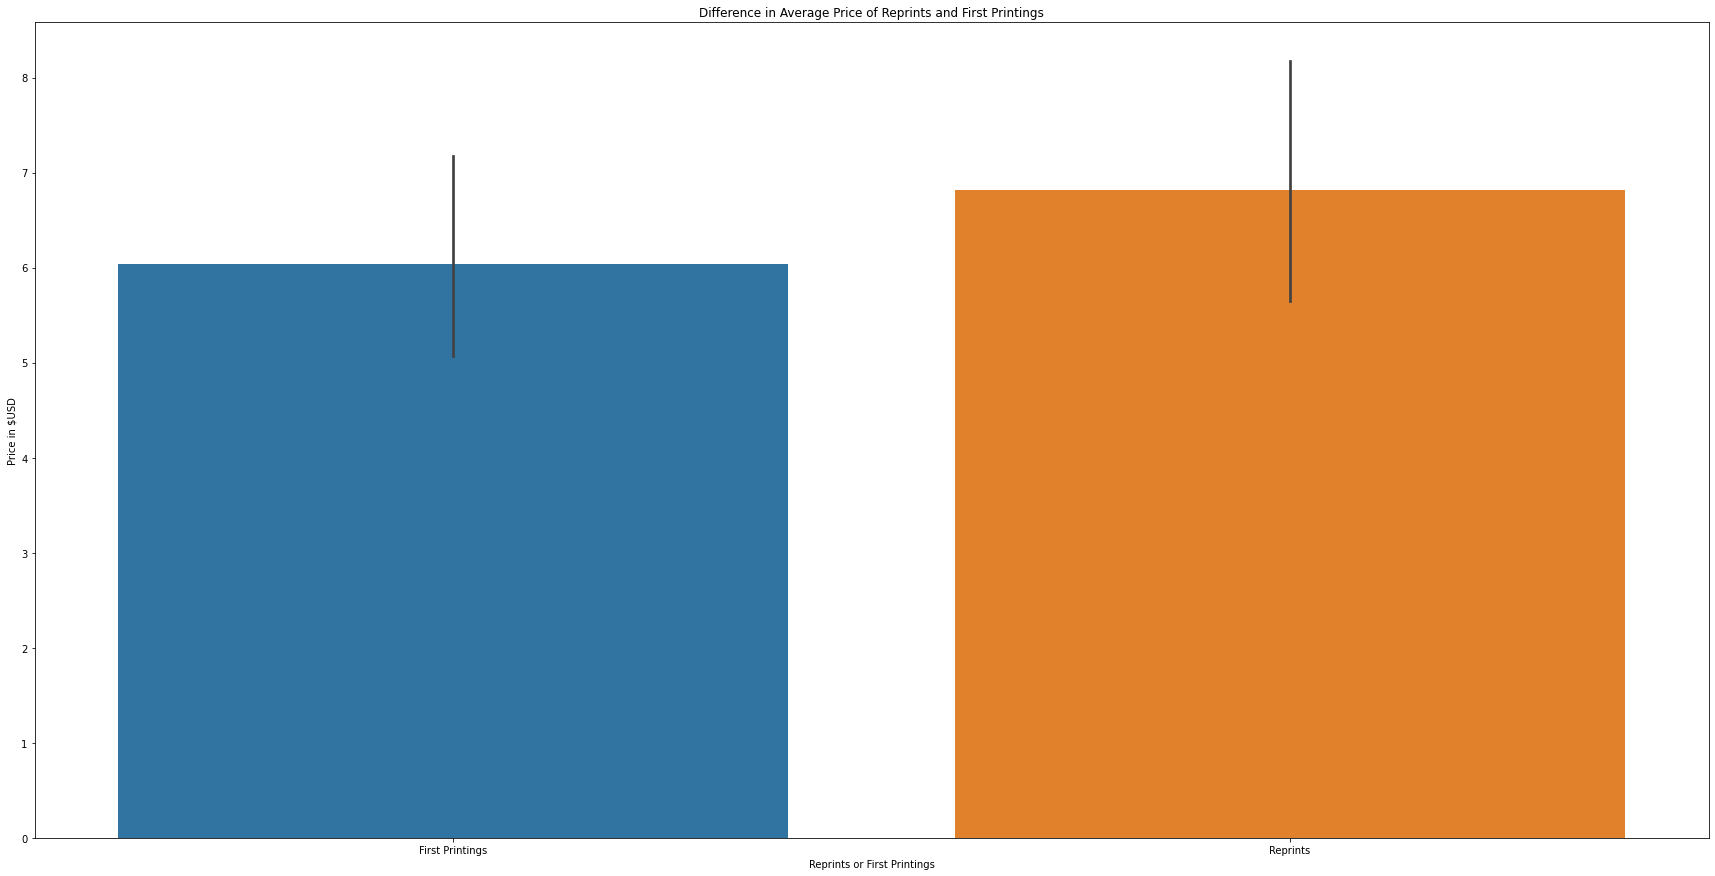

(None,
 'The average USD price of reprinted cards is $6.82,  and first print cards is $6.04. The difference in average price is $0.77.')

In [30]:
# # Combines explore functions for question two visualization
explore.reprint_or_not_viz(train)

#### Hypothesis Testing
95% significance level: α = 0.05
- $H_0$ = There is not a signficant difference in USD prices between reprints & first printings.
- $H_a$ = There is a significant difference in USD prices between reprints & first printings.

In [31]:
# # Hypothesis testing for question one using Two-sample T-Test with a 95% confidence interval
explore.hypothesis_test_reprint_or_not(train)

Variance for non-foil only cards is 7721.256.
Variance for cards with both foil and non-foil cards is 5609.148.
The t-statistic of -0.952 is less than 0, but the p-value of 1.705e-01 is not statistically significant.
We fail to reject the Null Hypothesis


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<a name='q_1'></a>
### How do cards with style treatments like frames or full art, affect their prices?

## Key takeaway
- 

## Discusion
- 
- 
- 

## Visualization

In [32]:
# # Combines explore functions for question three visualization
explore.stylized_or_not_viz(train)

NameError: name 'frame_effects_usd' is not defined

#### Hypothesis Testing
95% significance level: α = 0.05
- $H_0$ = There is not a signficant difference in USD prices between regular & styled cards.
- $H_a$ = There is a significant difference in USD prices between regular & styled cards.

In [ ]:
# # Hypothesis testing for question three using Two-sample T-Test with a 95% confidence interval
explore.q3_hypothesis_test(train)